<img src="https://swan.web.cern.ch/sites/swan.web.cern.ch/files/pictures/logo_swan_letters.png" alt="SWAN" style="float: left; width: 20%; margin-right: 15%; margin-left: 15%; margin-bottom: 2.0em;">
<img src="https://spark.apache.org/images/spark-logo-trademark.png" alt="EP-SFT" style="float: left; width: 25%; margin-right: 15%; margin-bottom: 2.0em;">
<p style="clear: both;">
<div style="text-align:center"><h1>Integration of SWAN with Spark clusters</h1></div>
<hr style="border-top-width: 4px; border-top-color: #34609b;">

The current setup allows to execute PySpark operations on CERN Hadoop and Spark clusters. 

This notebook illustrates the use of __Spark in SWAN to access CERN Accelerator logging service data__.

### Connect to the cluster (NXCals)
*Env - bleeding egde python3 & nxcals*

To connect to a cluster, click on the star button on the top and follow the instructions
* The star button only appears if you have selected a SPARK cluster in the configuration
* The star button is active after the notebook kernel is ready
* SELECT NXCALS configuration bundle
* Access to the cluster and NXCALS data is controlled by acc-logging-team, please write to acc-logging-team@cern.ch

### Read the NxCALS device properties into spark dataframe

In [1]:
# reference to NXCALS API - http://nxcals-docs.web.cern.ch/0.1.164/user-guide/library-reference/
# source the nxcals python libs
from cern.nxcals.pyquery.builders import *
from pyspark.sql import DataFrame

# build the query and load data into spark dataframe
df1 = DevicePropertyQuery \
            .builder(spark) \
            .system("CMW") \
            .startTime("2018-08-10 00:00:00.000") \
            .endTime("2018-08-11 00:00:00.000") \
            .entity() \
            .parameter("RADMON.PS-10/ExpertMonitoringAcquisition") \
            .buildDataset()

In [5]:
df1.count()

86399

### Inspect data

In [2]:
df1.select('acqStamp','voltage_18V','current_18V','device','pt100Value').toPandas()[:5]

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3_nxcals/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


acqStamp  voltage_18V  current_18V        device  pt100Value
0  1533859269309880000          NaN    38.262159  RADMON.PS-10  106.222734
1  1533860165318507000          NaN    38.292646  RADMON.PS-10  106.964769
2  1533860243319259000          NaN          NaN  RADMON.PS-10  106.222734
3  1533860353320318000          NaN    38.246915  RADMON.PS-10  106.311778
4  1533861186328377000          NaN          NaN  RADMON.PS-10  106.385982

### Draw a plot with matplotlib

In [3]:
import matplotlib
import pandas as pd
%matplotlib inline

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3_nxcals/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


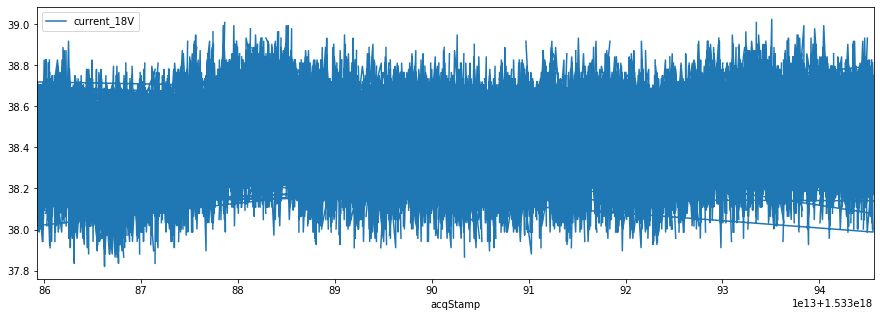

In [4]:
p_df = df1.select('acqStamp','current_18V').toPandas()
p_df.plot('acqStamp','current_18V',figsize=(15,5))
#p_df.sort_values(by='acqStamp').plot(pd.to_datetime(p_df['acqStamp'],unit='ns'),'current_18V',figsize=(15,5))

### Read TGM data

In [5]:
tgmData = DevicePropertyQuery \
                .builder(spark) \
                .system("CMW") \
                .startTime("2018-04-29 00:00:00.000") \
                .endTime("2018-05-01 00:00:00.000") \
                .entity() \
                .device("CPS.TGM") \
                .property("FULL-TELEGRAM.STRC") \
                .buildDataset()

In [6]:
tgmData.toPandas()[:2]

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3_nxcals/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pyspark/sql/dataframe.py:2102: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: StructType(List(StructField(elements,ArrayType(StringType,true),true),StructField(dimensions,ArrayType(IntegerType,true),true)))
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


BATCH  BEAMID  BPNM COMLN  CYCLE CYTAG     DEST DEST2  DURN FREE14  ...  \
0      0   38337    10  None      9  None  PS_DUMP  NONE     1   None  ...   
1      0   59846     5  None      5  None  EAST_T8  NTOF     2   None  ...   

  __LSA_CYCLE__ __record_timestamp__ __record_version__             acqStamp  \
0  TOF_SINGLEFB  1524960868300000000                  0  1524960868300000000   
1    EAST_IRRAD  1524961179100000000                  0  1524961179100000000   

     class           cyclestamp   device nxcals_entity_id            property  \
0  CPS.TGM  1524960868300000000  CPS.TGM            46955  FULL-TELEGRAM.STRC   
1  CPS.TGM  1524961179100000000  CPS.TGM            46955  FULL-TELEGRAM.STRC   

  selector  
0     None  
1     None  

[2 rows x 35 columns]

In [7]:
tgmData.groupBy("USER").count().show()

+--------+-----+
|    USER|count|
+--------+-----+
|   EAST1|12343|
|      AD| 1572|
|    LHC4| 1090|
|     MD1|  303|
|     MD6|   32|
|    LHC2|  621|
|LHCPROBE|  295|
|    ZERO|46588|
|     MD3|  323|
|     MD2|   53|
|   EAST2| 9866|
|     TOF|21220|
|     MD5|   36|
|LHCINDIV| 2014|
| SFTPRO2|18241|
+--------+-----+



In [8]:
tgm_df_dump = tgmData.select("cyclestamp", "USER","DEST").where("DEST = 'PS_DUMP' AND USER != 'ZERO'")
tgm_df_dump.show()

+-------------------+----+-------+
|         cyclestamp|USER|   DEST|
+-------------------+----+-------+
|1524960868300000000| TOF|PS_DUMP|
|1524973108300000000| TOF|PS_DUMP|
|1524984772300000000| TOF|PS_DUMP|
|1524987450700000000| TOF|PS_DUMP|
|1524994333900000000| TOF|PS_DUMP|
|1524976765900000000| TOF|PS_DUMP|
|1524989841100000000| TOF|PS_DUMP|
|1524991713100000000| TOF|PS_DUMP|
|1524992548300000000| TOF|PS_DUMP|
|1524994650700000000| TOF|PS_DUMP|
|1524961012300000000| TOF|PS_DUMP|
|1524972762700000000| TOF|PS_DUMP|
|1524980999500000000| TOF|PS_DUMP|
|1524981143500000000| TOF|PS_DUMP|
|1524969508300000000| TOF|PS_DUMP|
|1524971178700000000| TOF|PS_DUMP|
|1524971956300000000| TOF|PS_DUMP|
|1524972676300000000| TOF|PS_DUMP|
|1524977917900000000| TOF|PS_DUMP|
|1524986183500000000| TOF|PS_DUMP|
+-------------------+----+-------+
only showing top 20 rows



### Read FTN data

In [9]:
data = DevicePropertyQuery \
            .builder(spark) \
            .system("CMW") \
            .startTime("2018-04-29 00:00:00.000") \
            .endTime("2018-05-01 00:00:00.000") \
            .entity() \
            .device("FTN.QFO415S") \
            .property("Acquisition") \
            .buildDataset()

In [10]:
data.toPandas()[:2]

__record_timestamp__  __record_version__             acqStamp  acq_2  \
0   1524960240700000000                   0  1524960240800238525    NaN   
1   1524960276700000000                   0  1524960276800238525    NaN   

      class     current  current_max  current_min  current_status  \
0  PowM1553  114.982834          NaN          NaN             NaN   
1  PowM1553  114.982086          NaN          NaN             NaN   

   current_tola  current_tolr current_unit           cyclestamp       device  \
0           NaN           NaN         None  1524960240700000000  FTN.QFO415S   
1           NaN           NaN         None  1524960276700000000  FTN.QFO415S   

   nxcals_entity_id     property       selector  
0             54169  Acquisition  CPS.USER.ZERO  
1             54169  Acquisition   CPS.USER.TOF

In [11]:
data.describe("current").show()

+-------+--------------------+
|summary|             current|
+-------+--------------------+
|  count|              114597|
|   mean|  114.98358847391587|
| stddev|9.968958123980276E-4|
|    min|           114.97826|
|    max|           114.99046|
+-------+--------------------+



### Showing current sum for all *EAST* users:

In [12]:
from pyspark.sql.functions import sum
data.where("selector like '%EAST%'").select(sum(data.current)).show()

+------------------+
|      sum(current)|
+------------------+
|2553671.1740722656|
+------------------+



### Showing current sum for destination *TOF* using join:

In [13]:
tgmFiltered = tgmData.where("DEST like '%TOF%'")
tgmFiltered.count()
tgmFiltered.join(data, "cyclestamp").agg(sum(data.current)).show()

+------------------+
|      sum(current)|
+------------------+
|2291740.8582458496|
+------------------+



In [14]:
from cern.nxcals.pyquery.builders import *

df1 = VariableQuery.builder(spark)\
    .system('CMW').startTime('2018-04-29 00:00:00.000').endTime('2019-07-30 00:00:00.000')\
    .variable('LTB.BCT60:INTENSITY')\
    .buildDataset()

In [15]:
df1.show()

+----------------+-------------------+------------+--------------------+
|nxcals_entity_id|   nxcals_timestamp|nxcals_value|nxcals_variable_name|
+----------------+-------------------+------------+--------------------+
|           52034|1563235348865000000|   21202.625| LTB.BCT60:INTENSITY|
|           52034|1563235417265000000|    9473.184| LTB.BCT60:INTENSITY|
|           52034|1563235748465000000|   26251.283| LTB.BCT60:INTENSITY|
|           52034|1563235869665000000|   1463.2683| LTB.BCT60:INTENSITY|
|           52034|1563236306465000000|    71272.98| LTB.BCT60:INTENSITY|
|           52034|1563236338865000000|   7024.8125| LTB.BCT60:INTENSITY|
|           52034|1563236527265000000|   5461.9434| LTB.BCT60:INTENSITY|
|           52034|1563236535665000000|    21229.68| LTB.BCT60:INTENSITY|
|           52034|1563236601665000000|   17499.258| LTB.BCT60:INTENSITY|
|           52034|1563237016865000000|  -142.31503| LTB.BCT60:INTENSITY|
|           52034|1563237363665000000|   13438.458|

In [16]:
df1 = VariableQuery.builder(spark)\
    .system('CMW').startTime('2019-07-23 00:00:00.000').endTime('2019-07-30 00:00:00.000')\
    .variable('HX:BMODE_STATE')\
    .buildDataset()

In [17]:
df1.count()

604800